In [91]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
#import functools
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#import bindex
import contours2kml
import globalETAS as gep
from eq_params import *
#import roc_generic            # we'll eventually want to move to a new library of roc tools.
import random
#
#colors_ =  mpl.rcParams['axes.color_cycle']
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']		# make sure these are correct...
#
emc = {'lon':32.13, 'lat':-115.30, 'event_date':dtm.datetime(2010,4,4,22,40,41, tzinfo=pytz.timezone('UTC'))}
nepal_epi_lon = 84.698
nepal_epi_lat = 28.175


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
class LD_figure(object):
    def __init__(self, lat_center=nepal_epi_lat, lon_center=nepal_epi_lon, d_lat_auto=.5, d_lon_auto=.5,
                       to_dt=dtm.datetime(2015,4,30, tzinfo=pytz.timezone('UTC')), dt_0=30, mc=2.5,
                 mc_auto=4.5, d_lambda=1.76, dm=1.0, Ds=[1.0, 2.0], cat_len_plus=250.):
        '''
        # we want a liner density vs ETAS estimated linear densit figure.
        # first, get a catalog. find the biggest event in the catalog, plot linear distance from that event.
        # then, figure out the ETAS paramaters and see what we get and show for the domain 1. < D < 2.
        '''
        #
        #eqcat = atp.catfromANSS(lon=lons, lat=lats, minMag=cm, dates0=dates, Nmax=None, fout=None, rec_array=True)
        #eqcat.sort(order='event_date')
        # auto_cat(lon_center=None, lat_center=None, d_lat_0=.25, d_lon_0=.5, dt_0=10,  mc=2.5, mc_0=4.5, to_dt=None, catlen=5.0*365.0 range_factor=5., rec_array=True, **kwargs)
        eq_cat_params = atp.auto_cat_params(lat_center=lat_center, lon_center=lon_center,
                                            d_lat=d_lat_auto, d_lon=d_lon_auto, dt_0=dt_0, mc_0=mc_auto, 
                                            to_dt=to_dt, range_factor=5.)
        print('eq_cat_params: ', eq_cat_params)
        # r_val = mpd.num2date(mpd.datestr2num(date_in.astype(str)), tz=tz_out)
        eqcat = atp.catfromANSS(lat=eq_cat_params['lat'], lon=eq_cat_params['lon'], 
                                minMag=mc, dates0=[dtm64_to_datetime(eq_cat_params['mainshock_date']), 
                                                   dtm64_to_datetime(eq_cat_params['mainshock_date']) + dtm.timedelta(days=cat_len_plus)],
                                fout=None, rec_array=True)
        #
        # find the biggest event; dump everything before that.
        #eqcat.sort(order='mag')   # ... except that we want the index too. so let's just spin it:
        mainshock = eqcat[0]
        mainshock_index = 0
        for j,rw in enumerate(eqcat):
            if rw['mag']>mainshock['mag']: mainshock
            #
        #
        eqcat.sort(order='event_date')
        #
        # now, we need a distance formula. this can be using geographiclib or spherical dists. we could hook up some
        # of the class structures in the various etas codes...
        #dists = []
        #for j,ev in enumerate(eqcat):
        #    g1=ggp.WGS84.Inverse(self.mainshock['lat'], self.mainshock['lon'], rw['y'], rw['x'])
        #    r=g1['s12']/1000.)
        #
        dists = [[j,ggp.WGS84.Inverse(mainshock['lat'], mainshock['lon'], ev['lon'], ev['lat'])['s12']/1000.] 
                 for j,ev in enumerate(eqcat)]
        #
        dists2 =[[k,j,r] for k, (j,r) in enumerate(sorted(dists, key=lambda rw: rw[1]))]
        plt.figure()
        plt.plot(*zip(*[[r,k] for k,j,r in dists2]), '.-')
        #
        self.__dict__.update(locals())

# eventually, consolidate the generalized datetime-wrangler code.
def dtm64_to_datetime(x, tz_out=pytz.timezone('UTC')):
    if isinstance(x, dtm.datetime): return x
    return  mpd.num2date(mpd.datestr2num(x.astype(str)), tz=tz_out)

stuff:  28.175 84.698 0.5 0.25 4.5 2015-04-30 00:00:00+00:00
data handle fetched...
 no file.
cat_0:  9
mainshock data:  {'lat': 28.147300000000001, 'depth': 15.0, 'mag': 7.7999999999999998, 'event_date': numpy.datetime64('2015-04-25T01:11:26.270000-0500'), 'event_date_float': 735713.25794293976, 'lon': 84.707899999999995} 69.0192132301 3.10617521288 3.52278815046
eq_cat_params:  {'lat': [25.041124787122225, 31.253475212877778], 'mainshock_lat': 28.147300000000001, 'mainshock_lon': 84.707899999999995, 'lon': [81.185111849537464, 88.230688150462527], 'mainshock_date': numpy.datetime64('2015-04-25T01:11:26.270000-0500')}
data handle fetched...
 no file.


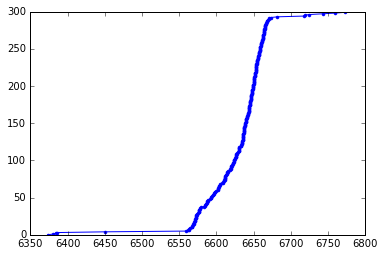

In [93]:
A = LD_figure()
# lats=[28.175-1., 28.175+1.], lons = [84.7-1., 84.7+1], to_dt=dtm.datetime(2015,5,1, tzinfo=pytz.timezone('UTC')) 
#

In [94]:


aa = atp.auto_cat_params(lon_center=nepal_epi_lon, lat_center=nepal_epi_lat, d_lat_0=.5, d_lon_0=.5,
                     dt_0=40, mc_0=4.5, to_dt=dtm.datetime(2015,4,30, tzinfo=pytz.timezone('UTC')),
                     range_factor=5.)

stuff:  28.175 84.698 0.5 0.5 4.5 2015-04-30 00:00:00+00:00
data handle fetched...
 no file.
cat_0:  12
mainshock data:  {'lat': 28.147300000000001, 'depth': 15.0, 'mag': 7.7999999999999998, 'event_date': numpy.datetime64('2015-04-25T01:11:26.270000-0500'), 'event_date_float': 735713.25794293976, 'lon': 84.707899999999995} 69.0192132301 3.10617521288 3.52278815046
